# Clustering large datasets with Birch

In [2]:
#import rasterio
import rasterio.windows
from rasterio.plot import show
from sklearn.cluster import KMeans, Birch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import random
import math

## Read the temperature tif file

Warning: the temperature data has values set very small to indicate that they are not actual values. You should give them some meaningful value when you display the image, and you should carefully consider what to do with them when you cluster. Discuss your approach in your writeup.

In [3]:
# You might need to run this twice before it actually shows the image.
# temp for "temperature" not "temporary"
temp = rasterio.open('20180901_usucampus_tir_celsius.tif')
print(f'number of bands: {temp.count}')
print(f'shape: {temp.shape}')
print('profile:')
display(temp.profile)

number of bands: 1
shape: (4627, 7736)
profile:


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 7736, 'height': 4627, 'count': 1, 'crs': CRS.from_dict(init='epsg:32612'), 'transform': Affine(0.13455000000000075, 0.0, 432151.133538606,
       0.0, -0.13455000000000075, 4621802.98036768), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

## Look at some additional properties of the image

In [4]:
print('projection: {}'.format(temp.crs))
#print('Affine transform (how raster is scaled, rotated, skewed, and/or translated):\n{}'.format(temp.affine))
print('width x height: {}x{}'.format(temp.width, temp.height))
print('number of bands: {}'.format(temp.count))
print('bounds: {}'.format(temp.bounds))
print('driver (data format): {}'.format(temp.driver))
print('no data values for all channels: {}'.format(temp.nodatavals))
print('all metadata: {}'.format(temp.meta))
    

projection: EPSG:32612
width x height: 7736x4627
number of bands: 1
bounds: BoundingBox(left=432151.133538606, bottom=4621180.41751768, right=433192.012338606, top=4621802.98036768)
driver (data format): GTiff
no data values for all channels: (-3.4028234663852886e+38,)
all metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 7736, 'height': 4627, 'count': 1, 'crs': CRS.from_dict(init='epsg:32612'), 'transform': Affine(0.13455000000000075, 0.0, 432151.133538606,
       0.0, -0.13455000000000075, 4621802.98036768)}


## Read a band and display the image

Different bands of a satellite images are often stacked together in one raster dataset. In our case, we only have one band. In order to have a closer look at the values stored in the band, we will take advantage of the [GDAL Band API](http://gdal.org/python/osgeo.gdal.Band-class.html).

In [5]:
def clamp_low(band):
    good_min = 0
    smallest = 0
    good_max = 0
    
    for bList in band:
        for val in bList:
            if (smallest > val):
                smallest = val
            if (good_min > val and val != smallest):
                good_min = val
            if (good_max < val):
                good_max = val
    return band, good_min, good_max
            
def remove_nan(band, lowMin):
    newBand = []
    for bList in band:
        print(len(bList))
        if bList[0] >= lowMin:
            newBand.append(bList)
    return newBand
    

In [6]:
plt.figure(figsize=(25,8))

# Read the entire first (and only band) into a numpy array
band1 = temp.read(1)
print(f'band type: {type(band1)}')
print(f'band shape: {band1.shape}')
print(f'band data type: {band1.dtype}')

# TODO: Need to do something with the small values set to indicate nan. You might consider
# implementing a function called clamp_low.
band1, good_min, good_max = clamp_low(band1)
print("GoodMin: ", good_min, " Good Max: ", good_max)




band type: <class 'numpy.ndarray'>
band shape: (4627, 7736)
band data type: float32
GoodMin:  -60.03  Good Max:  60.77


<Figure size 1800x576 with 0 Axes>

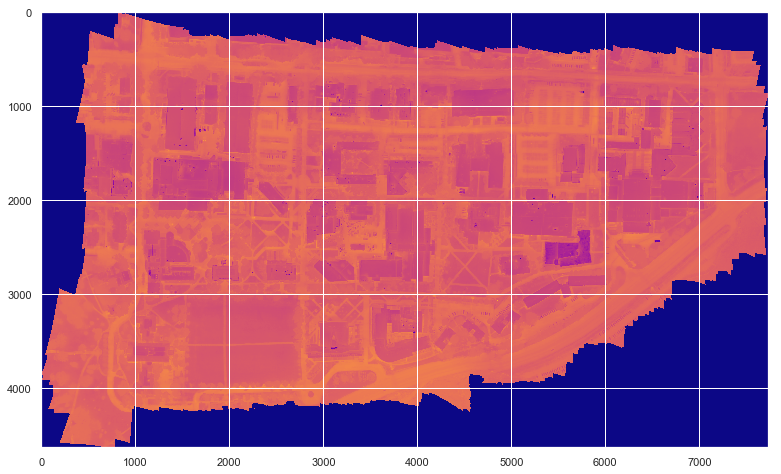

In [7]:
plt.figure(figsize=(25,8))
plt.imshow(band1, cmap='plasma', vmin=good_min, vmax=good_max)
plt.imshow(band1, cmap='plasma', vmin=good_min, vmax=good_max)

## Read chunks of the image and feed them into the Birch clustering algorithm

You will need to reshape the data to be one dimensional. If you don't Birch will think you have multiple attributes. (When you cluster on data including (x,y) coordinates, then your data will be three-dimensional, so your reshape call will be ```reshape(-1,3)```).Then consider how many pixels per batch you want to feed to the algorithm (if you feed all at once then it will be devastatingly slow). How big should your batch be? Do you need to feed all of your data to the clustering algorithm in order to get a good result? How many clusters is good? Experiment with all these parameters and discuss.

In [6]:
# TODO: break your data into batches

# Initialize Birch
# birch = Birch(n_clusters = k)

# Loop over some or all of your batches, then...
#    # Reshape to one dimension since we have only one feature (temperature)
#    X = batch[i].reshape(-1, 1)
#    birch.partial_fit(batch)
# Be sure to use partial_fit instead of fit so it doesn't rebuild the tree each time

# # See how clustering did on your original data and view the result
# shape = band1.shape
# y = birch.predict(band1.reshape(-1, 1))
# y = y.reshape(shape)

# Show the image
# plt.figure(figsize=(15,15))
# imgplot = plt.imshow(y)

In [8]:
# This is to reduce the size of the image to work with a smaller dataset
def CropIt(band, x0, y0, x1, y1):
    table = np.ndarray(shape=(x1-x0,y1-y0), dtype=float)
    for y in range(y0, y1):
        for x in range(x0, x1):
            table[y-y0][x-x0] = band[y][x]
    return table
    
    

def BatchIt(band, k):
    batch = []
    batches = []
    count = 0
    for bList in band:
        count += 1
        batch.append(bList)
        if count >= k:
            print("Batch: ", bList[0])
            batches.append(np.array(batch))
            batch = []
            count = 0
    return np.array(batches)
        
#grap spot where most temperature elements are present



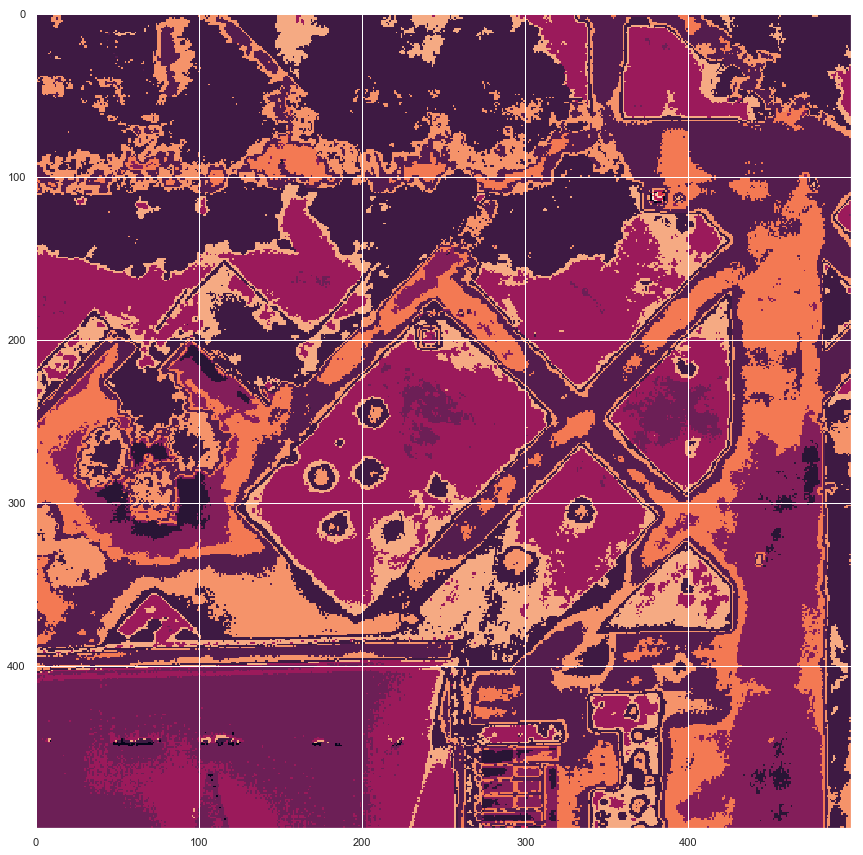

In [94]:
croppedBand = CropIt(band1, 2900, 3000, 3400, 3500)


# Initialize Birch
birch = Birch(n_clusters = 19)


X = croppedBand.reshape(-1,1)
brc = birch.fit(X)
shape = croppedBand.shape
y = birch.predict(croppedBand.reshape(-1, 1))
y = y.reshape(shape)
plt.figure(figsize=(15,15))
imgplot = plt.imshow(y)



<img src="smallRenderingLocation.png" style="height:400px">

C:\Users\Matthew\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


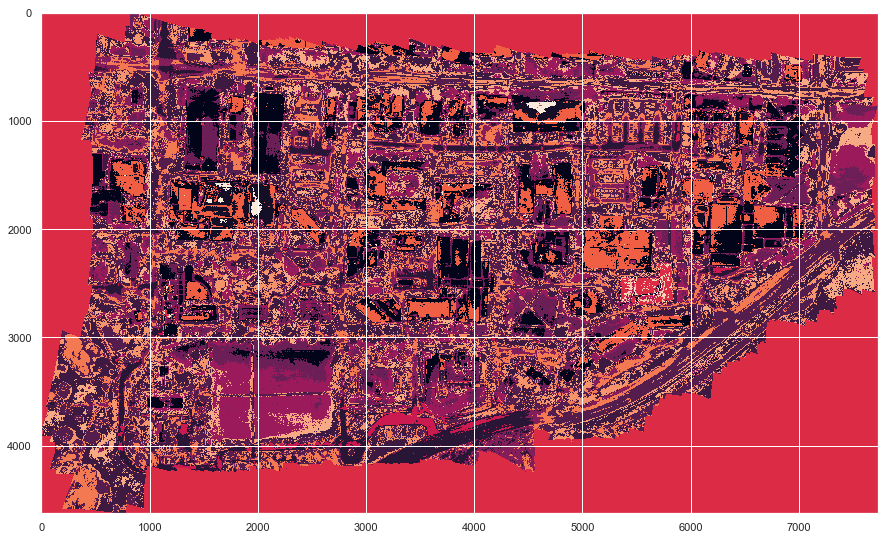

In [98]:
#croppedBand = CropIt(band1, 5000, 1000, 7000, 3000)

#we can use the same birch model to then look at the whole campus
shape = band1.shape
y = birch.predict(band1.reshape(-1, 1))
y = y.reshape(shape)
plt.figure(figsize=(15,15))
imgplot = plt.imshow(y)

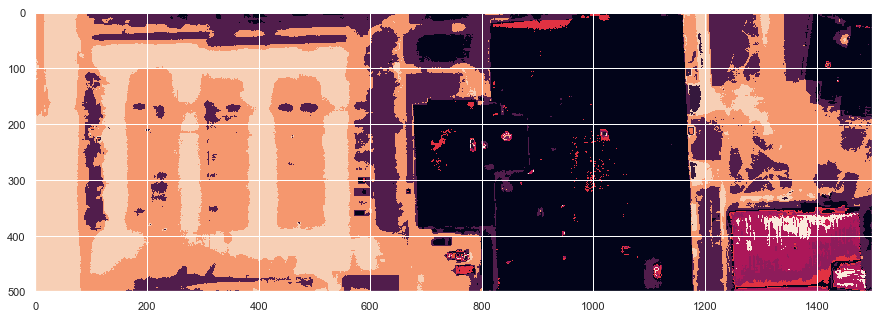

In [19]:
croppedBand = CropIt(band1, 5000, 1200, 5500, 2700)


# Initialize Birch
birch = Birch(n_clusters = 15)


X = croppedBand.reshape(-1,1)
brc = birch.fit(X)
shape = croppedBand.shape
y = birch.predict(croppedBand.reshape(-1, 1))
y = y.reshape(shape)
plt.figure(figsize=(15,15))
imgplot = plt.imshow(y)



C:\Users\Matthew\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


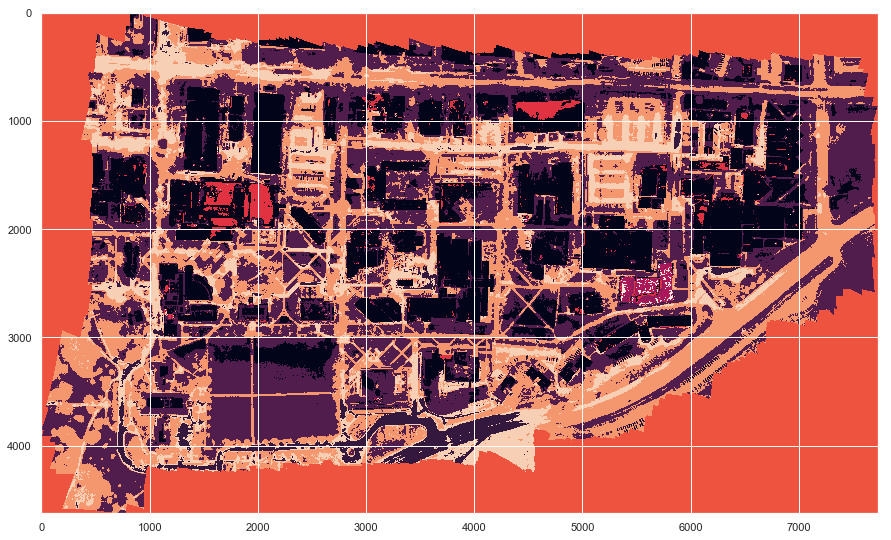

In [20]:
shape = band1.shape
y = birch.predict(band1.reshape(-1, 1))
y = y.reshape(shape)
plt.figure(figsize=(15,15))
imgplot = plt.imshow(y)

# Part Three

In [23]:
def DegradeResolution(band, spacing = 10, d = 3):
    if (d == 3):
        nBand = np.ndarray(shape=(int(band.shape[0]/spacing),int(band.shape[1]/spacing), 3))
    else:
        nBand = np.ndarray(shape=(int(band.shape[0]/spacing),int(band.shape[1]/spacing)))
    print("shape",nBand.shape, band.shape)
    Y = -1
    for y in range(0,band.shape[0]-spacing, spacing):
        Y += 1
        X = -1
        for x in range(0, band.shape[1]-spacing, spacing):
            X += 1
            if (d == 3):
                nBand[Y][X] = np.array([band[y][x], X, Y])
            else:
                nBand[Y][X] = band[y][x]
    return nBand
            
            
def CropIt3D(band, x0, y0, x1, y1):
    table = np.ndarray(shape=(y1-y0, x1-x0, 3))
    for x in range(x0, x1):
        for y in range(y0, y1):
            pixel = np.array([band[y][x], x, y])
            table[y-y0][x-x0] = pixel
    return table

def AddToBirch(birch, sample):
    X = sample.reshape(-1,3)
    birch.partial_fit(X)
    return birch





shape (308, 515) (4627, 7736)


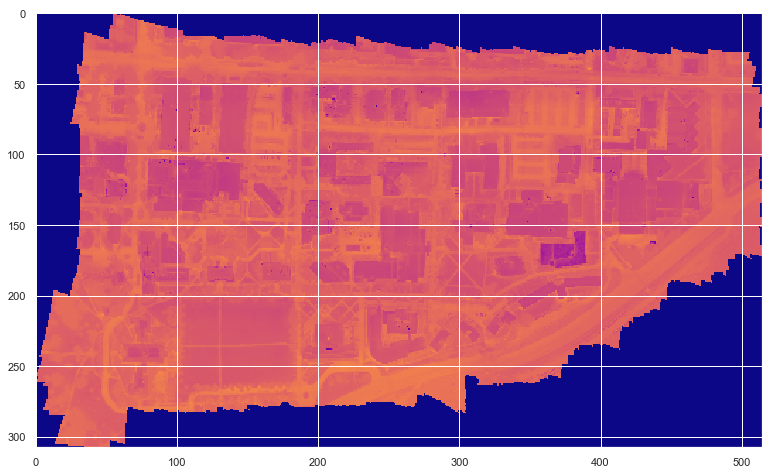

In [41]:
lrBand = DegradeResolution(band1, 15, 1)

plt.figure(figsize=(25,8))
plt.imshow(lrBand, cmap='plasma', vmin=good_min, vmax=good_max)
plt.imshow(lrBand, cmap='plasma', vmin=good_min, vmax=good_max)

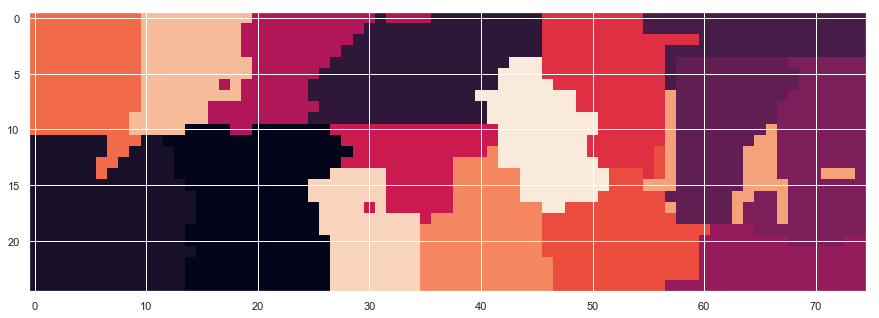

In [42]:
# Initialize Birch
birch = Birch(n_clusters = 17)


cropBand3D = CropIt3D(lrBand, 300, 160, 375, 185)
X = cropBand3D.reshape(-1,3)
brc = birch.partial_fit(X)
shape = cropBand3D.shape
y = birch.predict(cropBand3D.reshape(-1, 3))
y = y.reshape(shape[0:2])
plt.figure(figsize=(15,15))
imgplot = plt.imshow(y)


shape (308, 515, 3) (4627, 7736)


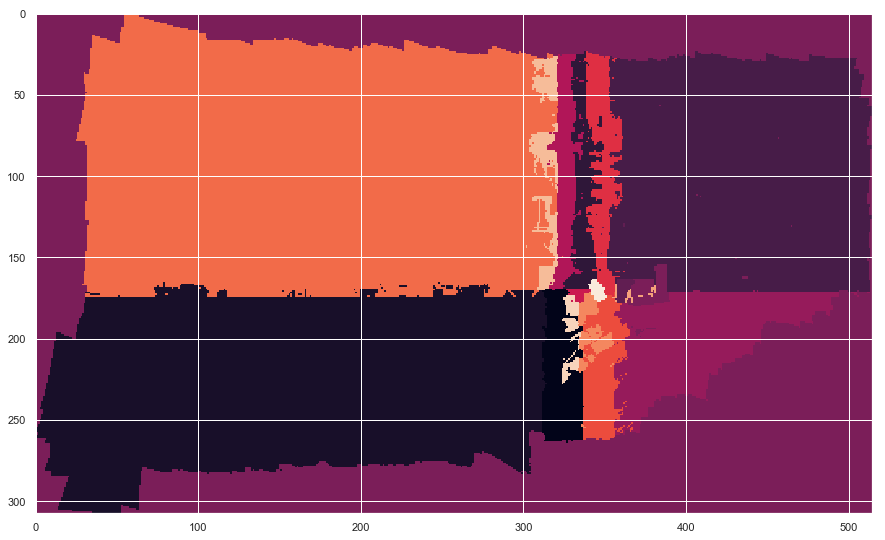

In [43]:
lrBand = DegradeResolution(band1, 15, 3)
shape = lrBand.shape
y = birch.predict(lrBand.reshape(-1, 3))
y = y.reshape(shape[0:2])
plt.figure(figsize=(15,15))
imgplot = plt.imshow(y)

shape (308, 515) (4627, 7736)


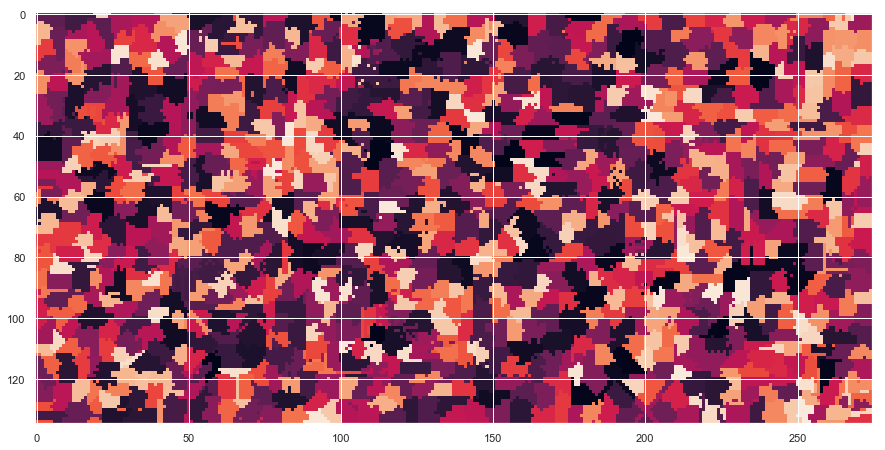

In [55]:
# Initialize Birch
birch = Birch(n_clusters = 1000)
lrBand = DegradeResolution(band1, 15, 1)

cropBand3D = CropIt3D(lrBand, 100, 50, 375, 185)
X = cropBand3D.reshape(-1,3)
brc = birch.partial_fit(X)
shape = cropBand3D.shape
y = birch.predict(cropBand3D.reshape(-1, 3))
y = y.reshape(shape[0:2])
plt.figure(figsize=(15,15))
imgplot = plt.imshow(y)

shape (231, 386, 3) (4627, 7736)


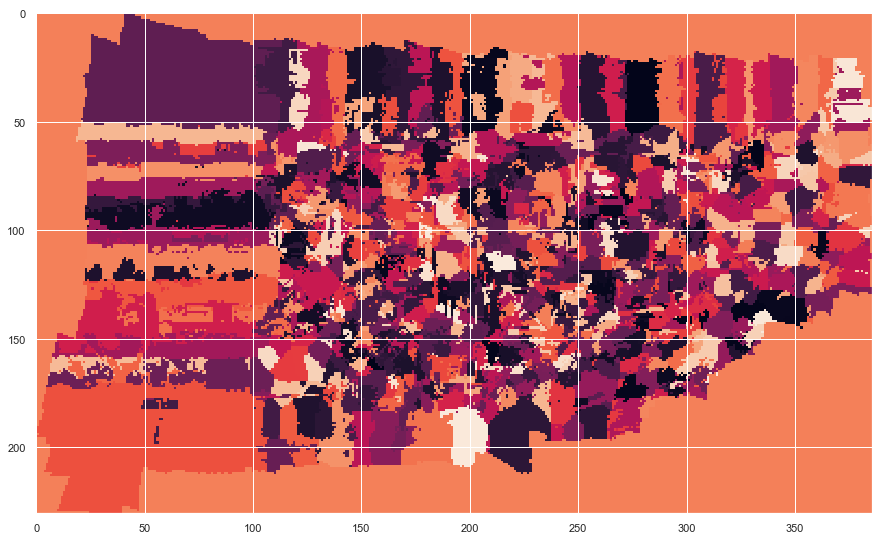

In [59]:
lrBand = DegradeResolution(band1, 20, 3)
shape = lrBand.shape
y = birch.predict(lrBand.reshape(-1, 3))
y = y.reshape(shape[0:2])
plt.figure(figsize=(15,15))
imgplot = plt.imshow(y)